# Install and load necesary packages

In [52]:
# Please don't change this cell

import pandas as pd
import numpy as np  

import warnings
warnings.filterwarnings("ignore")

## Load the dataset using pandas

In [53]:
# Please don't change this cell
df = pd.read_csv('ml-100k/u.data', names=['user_id', 'item_id', 'rating', 'timestamp'], sep='\t')

df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Split dataset


## Randomly select one rating from each user as test set

In [54]:
# please do not change this cell

from sklearn.model_selection import train_test_split

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

train_df, test_df = train_test_split(df, test_size=0.2, random_state = 10)
train_df, test_df

# Training Dataset
train_ds = np.zeros((n_users, n_items))
item_popularity = np.zeros(n_items)
for row in train_df.itertuples():
    train_ds[row[1]-1, row[2]-1] = row[3]
    item_popularity[row[2]-1] =  item_popularity[row[2]-1] + 1
#train_ds = pd.DataFrame(train_ds)

# Testing Dataset
testsize = 0
test_ds = np.zeros((n_users, n_items))
for row in test_df.itertuples():
    if item_popularity[row[2]-1] > 30:
        test_ds[row[1]-1, row[2]-1] = row[3]
        testsize = testsize + 1
#test_ds = pd.DataFrame(test_ds)

print("Construct the rating matrix based on train_df:")
print(train_ds)

print("Construct the rating matrix based on test_df:")
print(test_ds)

print("Testsize = " + str(testsize))

943 users
1682 items
Construct the rating matrix based on train_df:
[[0. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Construct the rating matrix based on test_df:
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Testsize = 17678


# MAE and RMSE Utils

In [55]:
# Please don't change this cell
# you can use this devaluate Utils here, and you can also implement your own MAE and RMSE calculation. 

EPSILON = 1e-9

def evaluate(test_ds, predicted_ds):
    '''
    Function for evaluating on MAE and RMSE
    '''
    # MAE
    mask_test_ds = test_ds > 0
    MAE = np.sum(np.abs(test_ds[mask_test_ds] - predicted_ds[mask_test_ds])) / np.sum(mask_test_ds.astype(np.float32))

    # RMSE
    RMSE = np.sqrt(np.sum(np.square(test_ds[mask_test_ds] - predicted_ds[mask_test_ds])) / np.sum(mask_test_ds.astype(np.float32)))

    return MAE, RMSE

# Your Solution for Method 1

In [56]:
# Write your code here for Method 1
# You are required to implement the required solution 1 here. 
# Then, evaluate your implementation by predicting the ratings in the test set (test_ds).
# Finally, save the corresponding MAE and RMSE of your implementation 
# into the following defined corresponding variable. 

# Method 1: User average rating

# create binary matrix for ratings (1 is rated, 0 is not rated)
ratings_mark = (train_ds > 0).astype(int)

# calculate user average ratings
user_rated_counts = ratings_mark.sum(axis=1)
user_ratings_sum = train_ds.sum(axis=1)
user_avg_ratings = user_ratings_sum / (user_rated_counts + EPSILON)

In [57]:
# Make predictions for the test set
predicted_ds_method1 = np.zeros_like(test_ds)
test_mask = test_ds > 0
for user_idx in range(n_users):
    user_test_items = test_mask[user_idx]
    predicted_ds_method1[user_idx, user_test_items] = user_avg_ratings[user_idx]


In [58]:
# get the MAE and RMSE of method 1
MAE_solution1, RMSE_solution1 = evaluate(test_ds, predicted_ds_method1)

In [59]:
# Please don't change this cell

print("===================== The MAE and RMSE of Your Implementation =====================")
print("MAE: {}, RMSE: {}" .format(MAE_solution1, RMSE_solution1))

===================== The MAE and RMSE of Your Implementation =====================
MAE: 0.8258905090160901, RMSE: 1.0311430705959619


# Your Solution for Method 2

In [60]:
# Method 2: item average rating
# create binary matrix for ratings (1 is rated, 0 is not rated)
ratings_mark = (train_ds > 0).astype(int)

# calculate user average ratings
item_rated_counts = ratings_mark.sum(axis=0)
item_rating_sums = train_ds.sum(axis=0)
item_avg_ratings = item_rating_sums / (item_rated_counts + EPSILON)

In [61]:
# Make predictions for test items
predicted_ds_method2 = np.zeros_like(test_ds)
test_mask = test_ds > 0

# Still need a loop for applying predictions
for item_idx in range(n_items):
    item_test_users = test_mask[:, item_idx]
    predicted_ds_method2[item_test_users, item_idx] = item_avg_ratings[item_idx]

In [62]:
MAE_solution2, RMSE_solution2 = evaluate(test_ds, predicted_ds_method2)

In [63]:
# Please don't change this cell

print("===================== The MAE and RMSE of Your Implementation =====================")
print("MAE: {}, RMSE: {}" .format(MAE_solution2, RMSE_solution2))

===================== The MAE and RMSE of Your Implementation =====================
MAE: 0.7961203951019012, RMSE: 1.001314210158761


# Your Solution for Method 3

#### Method 3: User knn based collaborative filtering 
- Compute the similarity by pearson similarity and cosine similarity, we could add another method to optimize such as Eucludian, in this case compare two correlations above.
- Then choose the better method, we tune the parameters. 
- By doing that, we find weight, then choose the k.

In [73]:
# Write your code here for Method 3
# func to compute Pearson similarity
def compute_pearson_similarity(train_data, sig_weight=25):
    n_users = train_data.shape[0]
    similarity_matrix = np.zeros((n_users, n_users))

    # pre calculate user ratings mean
    user_means = np.zeros(n_users)
    for i in range(n_users):
        mask = train_data[i] > 0
        if np.sum(mask) > 0:  
            user_means[i] = np.sum(train_data[i][mask]) / np.sum(mask)

    # compute similarity

    for i in range(n_users):
        # self similarity always equals to 1
        similarity_matrix[i, i] = 1.0

        for j in range(i + 1, n_users):
            # find co-rated items 
            mask_i = train_data[i] > 0
            mask_j = train_data[j] > 0
            corrated_idx = np.logical_and(mask_i, mask_j)
            corrated_items = np.where(corrated_idx)[0]

            if len(corrated_items) == 0:
                continue

            # center the ratings vectors
            user_i_centered = train_data[i][corrated_items] - user_means[i]
            user_j_centered = train_data[j][corrated_items] - user_means[j]

            # calculate the Pearson correlation coefficient
            r_ui_sub_r_i_sq = np.square(user_i_centered)
            r_uj_sub_r_j_sq = np.square(user_j_centered)

            r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
            r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

            sim = np.sum(user_i_centered * user_j_centered) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)
            weight_sim = (min(len(corrated_items), sig_weight) / sig_weight) * sim
            # Store in both positions (symmetric matrix)
            similarity_matrix[i, j] = weight_sim
            similarity_matrix[j, i] = weight_sim
    
    return similarity_matrix


In [74]:
# func to compute cosine similarity
def compute_consine_similarity(train_data, sig_weight=25):
    n_users = train_data.shape[0]
    similarity_matrix = np.zeros((n_users, n_users))

    # compute similarity
    for i in range(n_users):
        # self similarity always equals to 1
        similarity_matrix[i, i] = 1.0

        for j in range(i + 1, n_users):
            # find co-rated items 
            mask_i = train_data[i] > 0
            mask_j = train_data[j] > 0
            corrated_idx = np.logical_and(mask_i, mask_j)
            num_corated = np.sum(corrated_idx)

            # If no co-rated items, skip
            if num_corated == 0:
                continue

            # Extract ratings for co-rated items
            user_i_corated = train_data[i][corrated_idx]
            user_j_corated = train_data[j][corrated_idx]

            # Calculate cosine similarity
            dot_product = np.sum(user_i_corated * user_j_corated)
            norm_i = np.sqrt(np.sum(np.square(user_i_corated)))
            norm_j = np.sqrt(np.sum(np.square(user_j_corated)))

            sim = dot_product / (norm_i * norm_j + EPSILON)
            weighted_sim = (min(num_corated, sig_weight) / sig_weight) * sim
            
            # Store in both positions (symmetric matrix)
            similarity_matrix[i, j] = weighted_sim
            similarity_matrix[j, i] = weighted_sim
    
    return similarity_matrix

In [75]:
def compute_euclidean_similarity(train_data, sig_weight=25):
    n_users = train_data.shape[0]
    similarity_matrix = np.zeros((n_users, n_users))
    
    # Pre-calculate user means for normalized ratings
    user_means = np.zeros(n_users)
    for i in range(n_users):
        mask = train_data[i] > 0
        if np.sum(mask) > 0:
            user_means[i] = np.sum(train_data[i][mask]) / np.sum(mask)
    
    # Compute user-user similarity
    for i in range(n_users):
        # Self-similarity is always 1
        similarity_matrix[i, i] = 1.0
        
        for j in range(i + 1, n_users):
            # Find co-rated items
            mask_i = train_data[i] > 0
            mask_j = train_data[j] > 0
            corrated_idx = np.logical_and(mask_i, mask_j)
            corrated_items = np.where(corrated_idx)[0]
            
            if len(corrated_items) == 0:
                continue
            
            # Center the ratings by subtracting user means
            user_i_centered = train_data[i][corrated_items] - user_means[i]
            user_j_centered = train_data[j][corrated_items] - user_means[j]
            
            # Calculate Euclidean distance
            euclidean_dist = np.sqrt(np.sum(np.square(user_i_centered - user_j_centered)))
            
            # Convert distance to similarity (closer = more similar)
            max_dist = 4 * np.sqrt(len(corrated_items))  # Maximum possible distance
            
            # Convert to similarity value between 0 and 1
            sim = 1 / (1 + euclidean_dist / max_dist)
            
            # Apply significance weighting
            weighted_sim = (min(len(corrated_items), sig_weight) / sig_weight) * sim
            
            # Store in both positions (symmetric matrix)
            similarity_matrix[i, j] = weighted_sim
            similarity_matrix[j, i] = weighted_sim
    
    return similarity_matrix

In [76]:
# func to predict ratings using user-based collaborative filtering 
def predict_ratings(train_data, similarity_matrix, test_data, k=30):
    n_users, n_items = train_data.shape 
    predicted_ratings = np.zeros_like(test_data)
    test_mask = test_data > 0

    # pre-calculate user means to fill value for ratings if no neighbors rate the item
    user_means = np.zeros(n_users)
    for i in range(n_users):
        mask = train_data[i] > 0
        if np.sum(mask) > 0:
            user_means[i] = np.sum(train_data[i][mask]) / np.sum(mask)

    # Make the predict for all test items
    for i in range(n_users):
        user_test_items = np.where(test_mask[i])[0]
        if len(user_test_items) == 0:
            continue

        # Find the k most similar users (exluding self)
        similar_users = np.argsort(similarity_matrix[i])[::-1]
        similar_users = similar_users[similar_users != i][:k]

        for item_idx in user_test_items:
            # find the neighbors who rate that item
            mark_rated_item = train_data[similar_users, item_idx] > 0
            neighbors = similar_users[mark_rated_item]

            if len(neighbors) == 0:
                predicted_ratings[i, item_idx] = user_means[i]  # use user mean if no neighbors rated the item
                continue
        
            # Get similarities and ratings of neighbors 
            neighbor_similarities = similarity_matrix[i, neighbors]
            neighbor_ratings = train_data[neighbors, item_idx]

            # Calculate the neighbor means and weight difference
            neighbor_means = user_means[neighbors]
            weighted_diff = neighbor_ratings - neighbor_means

            # Calculate the predicted rating
            sim_sum = np.sum(neighbor_similarities) 
            prediction = user_means[i] + np.sum(neighbor_similarities * weighted_diff) / (sim_sum + EPSILON)
            predicted_ratings[i, item_idx] = np.clip(prediction, 1, 5)

    return predicted_ratings


In [78]:
from sklearn.model_selection import KFold

def cross_validate(train_data, sim_function, sig_weight=25, k=30, n_fold=3):

    # Create a mask for all rated items
    ratings_mask = train_data > 0

    # get indices of rated items
    user_indicies, item_indices = np.where(ratings_mask)
    ratings = train_data[user_indicies, item_indices]
    n_ratings = len(ratings)

    # set up KFold
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    # store metrics for each fold

    mae_scores = []
    rmse_scores = []

    # iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(n_ratings))):
        # make train and validation sets

        fold_train = train_data.copy()
        fold_val = np.zeros_like(train_data)

        # move validation ratings to validation set
        for i in val_idx:
            user, item = user_indicies[i], item_indices[i]
            fold_val[user, item] = ratings[i]
            fold_train[user, item] = 0
        
        # compute similarity matrix
        similarity_matrix = sim_function(fold_train, sig_weight)

        # predict ratings for validation set
        predicted_ratings = predict_ratings(fold_train, similarity_matrix, fold_val, k)

        # evaluate predictions
        mae, rmse = evaluate(fold_val, predicted_ratings)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
    
    # return average metrics for all folds
    return np.mean(mae_scores), np.mean(rmse_scores)
    

In [79]:
# Calculate all three similarity measures
mae_p, rmse_p = cross_validate(train_ds, compute_pearson_similarity)
print(f"Pearson cross-validation: MAE={mae_p:.4f}, RMSE={rmse_p:.4f}")

mae_c, rmse_c = cross_validate(train_ds, compute_consine_similarity)
print(f"Cosine cross-validation: MAE={mae_c:.4f}, RMSE={rmse_c:.4f}")

mae_e, rmse_e = cross_validate(train_ds, compute_euclidean_similarity)
print(f"Euclidean cross-validation: MAE={mae_e:.4f}, RMSE={rmse_e:.4f}")

# Find the best similarity measure
best_rmse = min(rmse_p, rmse_c, rmse_e)
if best_rmse == rmse_p:
    best_sim_method = "Pearson"
    best_sim_function = compute_pearson_similarity
    print("Pearson similarity performs better")
elif best_rmse == rmse_c:
    best_sim_method = "Cosine"
    best_sim_function = compute_consine_similarity
    print("Cosine similarity performs better")
else:
    best_sim_method = "Euclidean"
    best_sim_function = compute_euclidean_similarity
    print("Euclidean similarity performs better")

Pearson cross-validation: MAE=0.7906, RMSE=1.0196
Cosine cross-validation: MAE=0.7919, RMSE=1.0164
Euclidean cross-validation: MAE=0.7843, RMSE=1.0069
Euclidean similarity performs better


#### Using the elbow method

Running elbow method to find optimal significance weight...
sig_weight=5: MAE=0.8417, RMSE=1.0763
sig_weight=15: MAE=0.7955, RMSE=1.0202
sig_weight=25: MAE=0.7843, RMSE=1.0069
sig_weight=40: MAE=0.7792, RMSE=1.0022
sig_weight=60: MAE=0.7793, RMSE=1.0033
sig_weight=80: MAE=0.7800, RMSE=1.0043


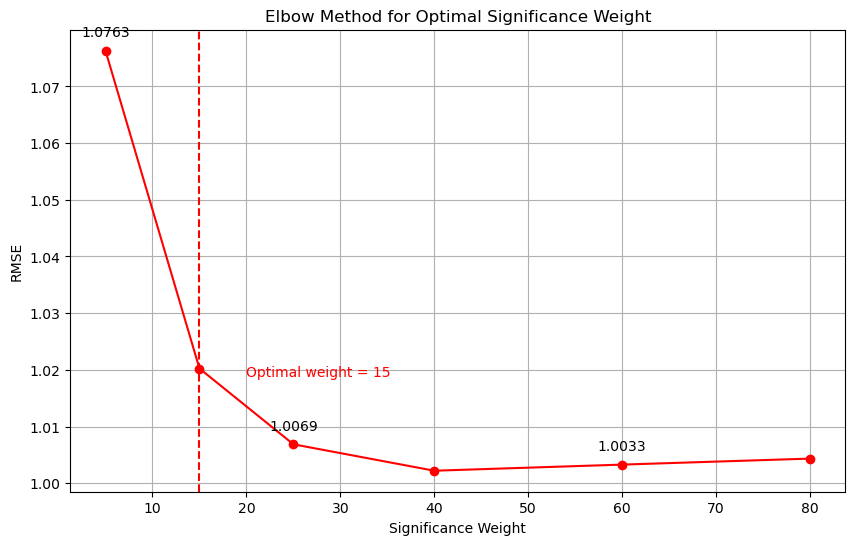


Percentage improvements in RMSE for significance weights:
From weight=5 to weight=15: 5.21%
From weight=15 to weight=25: 1.31%
From weight=25 to weight=40: 0.46%
From weight=40 to weight=60: -0.11%
From weight=60 to weight=80: -0.11%

Selected best significance weight = 15


In [80]:
import matplotlib.pyplot as plt

# Compute similarity matrix first with default weight
final_sim_matrix = best_sim_function(train_ds, sig_weight=25)

# 1. First apply elbow method to find the optimal significance weight
print("Running elbow method to find optimal significance weight...")
sig_weights_extended = [5, 15, 25, 40, 60, 80]
sig_mae_scores = []
sig_rmse_scores = []

for sig_weight in sig_weights_extended:
    mae, rmse = cross_validate(train_ds, best_sim_function, sig_weight=sig_weight)
    sig_mae_scores.append(mae)
    sig_rmse_scores.append(rmse)
    print(f"sig_weight={sig_weight}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Plot the elbow curve for significance weight
plt.figure(figsize=(10, 6))
plt.plot(sig_weights_extended, sig_rmse_scores, 'ro-')
plt.xlabel('Significance Weight')
plt.ylabel('RMSE')
plt.title('Elbow Method for Optimal Significance Weight')
plt.grid(True)

# Add annotations for clarity
for i, weight in enumerate(sig_weights_extended):
    if i % 2 == 0:  # Annotate every other point to avoid crowding
        plt.annotate(f'{sig_rmse_scores[i]:.4f}', 
                    (weight, sig_rmse_scores[i]), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')

# Find the elbow point for significance weight
# Calculate approximate second derivative
sig_rmse_array = np.array(sig_rmse_scores)
sig_deltas = np.diff(sig_rmse_array, 2)  # Second derivative

if len(sig_deltas) > 0:
    sig_elbow_idx = np.argmax(np.abs(sig_deltas)) + 1  # +1 because of the diff
    optimal_sig_weight = sig_weights_extended[sig_elbow_idx]
    plt.axvline(x=optimal_sig_weight, color='r', linestyle='--')
    plt.text(optimal_sig_weight+5, np.mean(sig_rmse_scores), f'Optimal weight = {optimal_sig_weight}', color='r')
else:
    # If not enough points for second derivative, use minimum
    optimal_sig_weight = sig_weights_extended[np.argmin(sig_rmse_scores)]

plt.savefig('elbow_method_weight_selection.png')
plt.show()

# Print percentage improvements for significance weight
sig_improvements = []
for i in range(1, len(sig_rmse_scores)):
    improvement = (sig_rmse_scores[i-1] - sig_rmse_scores[i]) / sig_rmse_scores[i-1] * 100
    sig_improvements.append(improvement)
    
print("\nPercentage improvements in RMSE for significance weights:")
for i, imp in enumerate(sig_improvements):
    print(f"From weight={sig_weights_extended[i]} to weight={sig_weights_extended[i+1]}: {imp:.2f}%")

# Use the optimal significance weight for the next step
best_sig_weight = optimal_sig_weight
print(f"\nSelected best significance weight = {best_sig_weight}")

# Recompute similarity matrix with optimal significance weight



Running elbow method to find optimal k...
k=5: MAE=0.8601, RMSE=1.1004
k=15: MAE=0.8259, RMSE=1.0602
k=30: MAE=0.7955, RMSE=1.0202
k=50: MAE=0.7756, RMSE=0.9935
k=80: MAE=0.7627, RMSE=0.9757
k=120: MAE=0.7559, RMSE=0.9664


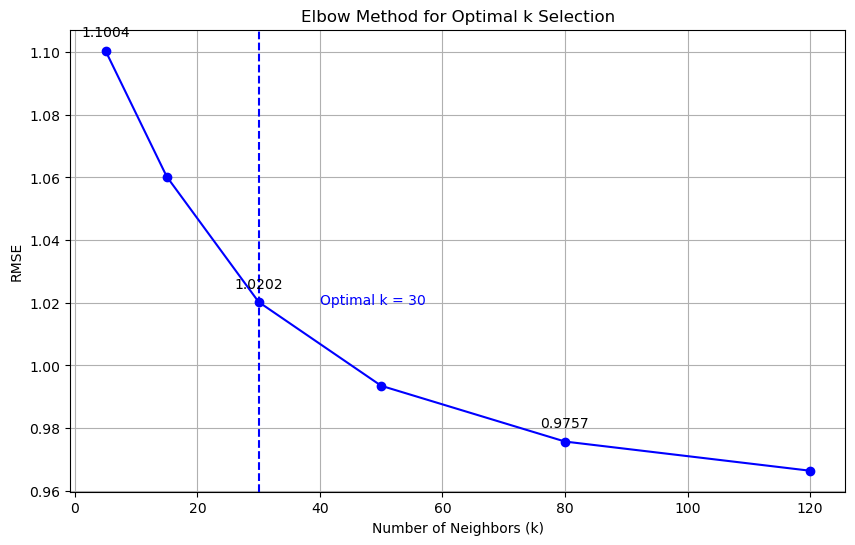


Percentage improvements in RMSE for k values:
From k=5 to k=15: 3.65%
From k=15 to k=30: 3.77%
From k=30 to k=50: 2.62%
From k=50 to k=80: 1.79%
From k=80 to k=120: 0.95%

Based on marginal improvements (<0.1%), best k = 120
Based on elbow method (maximum curvature), best k = 30

Selected best k = 30

Final optimal parameters:
Similarity method: Euclidean
Significance weight: 15
Number of neighbors (k): 30

Final Method 3 performance with optimal parameters:
MAE: 0.7753
RMSE: 0.9959


In [81]:
final_sim_matrix = best_sim_function(train_ds, sig_weight=best_sig_weight)

# 2. Now apply elbow method to find the optimal k value
print("\nRunning elbow method to find optimal k...")
k_values_extended = [5, 15, 30, 50, 80, 120]
k_mae_scores = []
k_rmse_scores = []

for k in k_values_extended:
    mae, rmse = cross_validate(train_ds, best_sim_function, sig_weight=best_sig_weight, k=k)
    k_mae_scores.append(mae)
    k_rmse_scores.append(rmse)
    print(f"k={k}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Plot the elbow curve for k
plt.figure(figsize=(10, 6))
plt.plot(k_values_extended, k_rmse_scores, 'bo-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('Elbow Method for Optimal k Selection')
plt.grid(True)

# Add annotations
for i, k in enumerate(k_values_extended):
    if i % 2 == 0:  # Annotate every other point
        plt.annotate(f'{k_rmse_scores[i]:.4f}', 
                    (k, k_rmse_scores[i]), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')

# Find the elbow point for k
k_rmse_array = np.array(k_rmse_scores)
k_deltas = np.diff(k_rmse_array, 2)  # Second derivative

if len(k_deltas) > 0:
    k_elbow_idx = np.argmax(np.abs(k_deltas)) + 1  # +1 because of the diff
    optimal_k = k_values_extended[k_elbow_idx]
    plt.axvline(x=optimal_k, color='b', linestyle='--')
    plt.text(optimal_k+10, np.mean(k_rmse_scores), f'Optimal k = {optimal_k}', color='b')
else:
    # If not enough points for second derivative, use minimum
    optimal_k = k_values_extended[np.argmin(k_rmse_scores)]

plt.savefig('elbow_method_k_selection.png')
plt.show()

# Calculate percentage improvements for k
k_improvements = []
for i in range(1, len(k_rmse_scores)):
    improvement = (k_rmse_scores[i-1] - k_rmse_scores[i]) / k_rmse_scores[i-1] * 100
    k_improvements.append(improvement)
    
print("\nPercentage improvements in RMSE for k values:")
for i, imp in enumerate(k_improvements):
    print(f"From k={k_values_extended[i]} to k={k_values_extended[i+1]}: {imp:.2f}%")

# Find where improvements become marginal (e.g., less than 0.1%)
marginal_idx = next((i for i, imp in enumerate(k_improvements) if abs(imp) < 0.1), len(k_improvements)-1)
best_k_marginal = k_values_extended[marginal_idx+1]
print(f"\nBased on marginal improvements (<0.1%), best k = {best_k_marginal}")
print(f"Based on elbow method (maximum curvature), best k = {optimal_k}")

# Choose the optimal k based on elbow detection
best_k = optimal_k
print(f"\nSelected best k = {best_k}")

# Generate final predictions with optimal parameters
print("\nFinal optimal parameters:")
print(f"Similarity method: {best_sim_method}")
print(f"Significance weight: {best_sig_weight}")
print(f"Number of neighbors (k): {best_k}")

# Re-compute final similarity matrix with optimal parameters (just to be sure)
final_sim_matrix = best_sim_function(train_ds, sig_weight=best_sig_weight)

# Generate predictions on the test set using optimal parameters
final_predictions = predict_ratings(train_ds, final_sim_matrix, test_ds, k=best_k)

# Evaluate final performance
MAE_solution3, RMSE_solution3 = evaluate(test_ds, final_predictions)

print(f"\nFinal Method 3 performance with optimal parameters:")
print(f"MAE: {MAE_solution3:.4f}")
print(f"RMSE: {RMSE_solution3:.4f}")

#### try different k and weights manually

In [ ]:
# # Move to another step to test different weights for neighbors
# sig_weights = [15, 25, 40, 60]
# best_sig_weight = 25  # set it as default
# best_sig_rmse = float('inf')

# for sig_weight in sig_weights:
#     mae, rmse = cross_validate(train_ds, best_sim_function, sig_weight=sig_weight)
#     print(f"Significance weight {sig_weight}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    
#     if rmse < best_sig_rmse:
#         best_sig_rmse = rmse
#         best_sig_weight = sig_weight

# print(f"Best significance weight: {best_sig_weight}")

Significance weight 15: MAE=0.7955, RMSE=1.0202
Significance weight 25: MAE=0.7843, RMSE=1.0069
Significance weight 40: MAE=0.7792, RMSE=1.0022


KeyboardInterrupt: 

In [ ]:
# # find the best k for neighbors
# k_values = [20, 30, 50, 80, 100]
# best_k = 30  # Default
# best_k_rmse = float('inf')

# for k in k_values:
#     mae, rmse = cross_validate(train_ds, best_sim_function, sig_weight=best_sig_weight, k=k)
#     print(f"k={k}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    
#     if rmse < best_k_rmse:
#         best_k_rmse = rmse
#         best_k = k

# print(f"Best k: {best_k}")


k=20: MAE=0.7836, RMSE=1.0135
k=30: MAE=0.7691, RMSE=0.9923
k=50: MAE=0.7548, RMSE=0.9728
k=80: MAE=0.7467, RMSE=0.9605
k=100: MAE=0.7443, RMSE=0.9564
Best k: 100


In [ ]:
# # Summarize the best parameters 
# print("\nBest parameters found through cross-validation:")
# print(f"Similarity method: {best_sim_method}")
# print(f"Significance weight: {best_sig_weight}")
# print(f"Number of neighbors (k): {best_k}")
# print(f"Cross-validation RMSE: {best_k_rmse:.4f}")

# # compute the final similarity matrix with optimal parameters
# final_sim_matrix = best_sim_function(train_ds, sig_weight=best_sig_weight)

# # Generate predictions on the test set using optimal parameters
# final_predictions = predict_ratings(train_ds, final_sim_matrix, test_ds, k=best_k)

# # Evaluate final performance
# MAE_solution3, RMSE_solution3 = evaluate(test_ds, final_predictions)

# print(f"\nFinal Method 3 performance on test set:")
# print(f"MAE: {MAE_solution3:.4f}")
# print(f"RMSE: {RMSE_solution3:.4f}")


Best parameters found through cross-validation:
Similarity method: Pearson
Significance weight: 60
Number of neighbors (k): 100
Cross-validation RMSE: 0.9564

Final Method 3 performance on test set:
MAE: 0.7218
RMSE: 0.9323


In [83]:
# Please don't change this cell

print("===================== The MAE and RMSE of Your Implementation =====================")
print("MAE: {}, RMSE: {}" .format(MAE_solution3, RMSE_solution3))

===================== The MAE and RMSE of Your Implementation =====================
MAE: 0.7753241569148077, RMSE: 0.9959277052183921


# Your Solution for Method 4

In [84]:
# Method 4: Item based collaborative filtering
# Function to compute item-item adjusted cosine similarity
def compute_item_cosine_similarity(train_data, sig_weight=25):
    n_users, n_items = train_data.shape
    similarity_matrix = np.zeros((n_items, n_items))
    
    # Pre-calculate user means for centered ratings
    user_means = np.zeros(n_users)
    for i in range(n_users):
        mask = train_data[i] > 0
        if np.sum(mask) > 0:
            user_means[i] = np.sum(train_data[i][mask]) / np.sum(mask)
    
    # Compute item-item similarity
    for i in range(n_items):
        # Self-similarity is always 1
        similarity_matrix[i, i] = 1.0
        
        for j in range(i + 1, n_items):
            # Find users who rated both items
            mask_i = train_data[:, i] > 0
            mask_j = train_data[:, j] > 0
            common_users = np.logical_and(mask_i, mask_j)
            common_user_indices = np.where(common_users)[0]
            
            # Skip if no common users
            if len(common_user_indices) == 0:
                continue
            
            # Center the ratings by subtracting user means
            item_i_centered = train_data[common_user_indices, i] - user_means[common_user_indices]
            item_j_centered = train_data[common_user_indices, j] - user_means[common_user_indices]
            
            # Calculate adjusted cosine similarity
            numerator = np.sum(item_i_centered * item_j_centered)
            denominator = np.sqrt(np.sum(np.square(item_i_centered))) * np.sqrt(np.sum(np.square(item_j_centered)))
            
            # Compute similarity with significance weighting
            sim = numerator / (denominator + EPSILON)
            # Apply significance weighting
            weighted_sim = (min(len(common_user_indices), sig_weight) / sig_weight) * sim
                
            # Store in both positions (symmetric matrix)
            similarity_matrix[i, j] = weighted_sim
            similarity_matrix[j, i] = weighted_sim                
    
    return similarity_matrix

In [85]:
# Function to compute item-item Pearson correlation
def compute_item_pearson_similarity(train_data, sig_weight=25):
    n_users, n_items = train_data.shape
    similarity_matrix = np.zeros((n_items, n_items))
    
    # Pre-calculate item means
    item_means = np.zeros(n_items)
    for i in range(n_items):
        mask = train_data[:, i] > 0
        if np.sum(mask) > 0:
            item_means[i] = np.sum(train_data[mask, i]) / np.sum(mask)
    
    # Compute item-item similarity
    for i in range(n_items):
        # Self-similarity is always 1
        similarity_matrix[i, i] = 1.0
        
        for j in range(i + 1, n_items):
            # Find users who rated both items
            mask_i = train_data[:, i] > 0
            mask_j = train_data[:, j] > 0
            common_users = np.logical_and(mask_i, mask_j)
            common_user_indices = np.where(common_users)[0]
            
            # Skip if no common users
            if len(common_user_indices) == 0:
                continue
            
            # Center the ratings by subtracting item means
            item_i_centered = train_data[common_user_indices, i] - item_means[i]
            item_j_centered = train_data[common_user_indices, j] - item_means[j]
            
            # Calculate Pearson correlation
            numerator = np.sum(item_i_centered * item_j_centered)
            denominator = np.sqrt(np.sum(np.square(item_i_centered))) * np.sqrt(np.sum(np.square(item_j_centered)))
            
            # Compute similarity with significance weighting
            sim = numerator / (denominator + EPSILON)
            # Apply significance weighting
            weighted_sim = (min(len(common_user_indices), sig_weight) / sig_weight) * sim
            
            # Store in both positions (symmetric matrix)
            similarity_matrix[i, j] = weighted_sim
            similarity_matrix[j, i] = weighted_sim
                
    
    return similarity_matrix

In [86]:
# Function to compute item-item Euclidean distance similarity
def compute_item_euclidean_similarity(train_data, sig_weight=25):
    n_users, n_items = train_data.shape
    similarity_matrix = np.zeros((n_items, n_items))
    
    # Pre-calculate user means for normalized ratings
    user_means = np.zeros(n_users)
    for i in range(n_users):
        mask = train_data[i] > 0
        if np.sum(mask) > 0:
            user_means[i] = np.sum(train_data[i][mask]) / np.sum(mask)
    
    # Compute item-item similarity
    for i in range(n_items):
        # Self-similarity is always 1
        similarity_matrix[i, i] = 1.0
        
        for j in range(i + 1, n_items):
            # Find users who rated both items
            mask_i = train_data[:, i] > 0
            mask_j = train_data[:, j] > 0
            common_users = np.logical_and(mask_i, mask_j)
            common_user_indices = np.where(common_users)[0]
            
            # Skip if no common users
            if len(common_user_indices) == 0:
                continue
            
            # Center the ratings by subtracting user means
            item_i_centered = train_data[common_user_indices, i] - user_means[common_user_indices]
            item_j_centered = train_data[common_user_indices, j] - user_means[common_user_indices]
            
            # Calculate Euclidean distance
            euclidean_dist = np.sqrt(np.sum(np.square(item_i_centered - item_j_centered)))
            
            # Convert distance to similarity (closer = more similar)
            # Use max rating scale (4) as normalization factor for distance
            max_dist = 4 * np.sqrt(len(common_user_indices))  # Maximum possible distance
            
            # Convert to similarity value between 0 and 1 (inverse of normalized distance)
            sim = 1 / (1 + euclidean_dist / max_dist)
            
            # Apply significance weighting
            weighted_sim = (min(len(common_user_indices), sig_weight) / sig_weight) * sim
            
            # Store in both positions (symmetric matrix)
            similarity_matrix[i, j] = weighted_sim
            similarity_matrix[j, i] = weighted_sim
    
    return similarity_matrix

In [87]:
# Function to predict ratings using item-based collaborative filtering
def predict_item_ratings(train_data, item_similarity, test_data, k=30):
    n_users, n_items = train_data.shape
    predicted_ratings = np.zeros_like(test_data)
    test_mask = test_data > 0
    
    # Pre-calculate item averages for fallback prediction
    item_means = np.zeros(n_items)
    for i in range(n_items):
        mask = train_data[:, i] > 0
        if np.sum(mask) > 0:
            item_means[i] = np.sum(train_data[mask, i]) / np.sum(mask)
    
    # For each user and each test item, make predictions
    for user_idx in range(n_users):
        # Get items that need prediction for this user
        user_test_items = np.where(test_mask[user_idx])[0]
        if len(user_test_items) == 0:
            continue
        
        # Get items already rated by this user
        user_rated_items = np.where(train_data[user_idx] > 0)[0]
        if len(user_rated_items) == 0:
            continue
        
        # For each test item, predict rating
        for item_idx in user_test_items:
            # Find k most similar items to the current item (excluding itself)
            similar_items = np.argsort(item_similarity[item_idx])[::-1]
            similar_items = similar_items[similar_items != item_idx][:k]
            
            # Keep only items that the user has rated
            common_items = np.intersect1d(similar_items, user_rated_items)
            
            if len(common_items) == 0:
                # No similar items rated by user, use item average
                predicted_ratings[user_idx, item_idx] = item_means[item_idx]
                continue
            
            # Get similarities and ratings of the user for those items
            item_similarities = item_similarity[item_idx, common_items]
            user_ratings = train_data[user_idx, common_items]
            
            # Calculate the weighted average
            sim_sum = np.sum(np.abs(item_similarities))  # Use absolute similarities for stability
            prediction = np.sum(item_similarities * user_ratings) / (sim_sum + EPSILON)
            
            # Clip the prediction to valid rating range
            predicted_ratings[user_idx, item_idx] = np.clip(prediction, 1, 5)
    
    return predicted_ratings

In [88]:
# Cross-validation function for item-based CF
def cross_validate_item_cf(train_data, similarity_function, sig_weight=25, k=30, n_fold=3):
    """
    Perform cross-validation to evaluate item-based collaborative filtering
    """
    # Create a mask for all rated items
    ratings_mask = train_data > 0
    
    # Get indices of rated items
    user_indices, item_indices = np.where(ratings_mask)
    ratings = train_data[user_indices, item_indices]
    n_ratings = len(ratings)
    
    # Set up KFold
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    
    # Store metrics for each fold
    mae_scores = []
    rmse_scores = []
    
    # Iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(n_ratings))):
        # Make train and validation sets
        fold_train = train_data.copy()
        fold_val = np.zeros_like(train_data)
        
        # Move validation ratings to validation set
        for i in val_idx:
            user, item = user_indices[i], item_indices[i]
            fold_val[user, item] = ratings[i]
            fold_train[user, item] = 0
        
        # Compute item similarity matrix
        item_sim_matrix = similarity_function(fold_train, sig_weight)
        
        # Predict ratings for validation set
        predicted_ratings = predict_item_ratings(fold_train, item_sim_matrix, fold_val, k)
        
        # Evaluate predictions
        mae, rmse = evaluate(fold_val, predicted_ratings)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
    
    # Return average metrics for all folds
    return np.mean(mae_scores), np.mean(rmse_scores)

In [89]:
similarity_functions = {
    "Cosine": compute_item_cosine_similarity,
    "Pearson": compute_item_pearson_similarity,
    "Euclidean": compute_item_euclidean_similarity
}

# Test each similarity function with default parameters
best_sim_name = None
best_sim_function = None
best_rmse = float('inf')

for name, sim_function in similarity_functions.items():
    mae, rmse = cross_validate_item_cf(train_ds, sim_function)
    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_sim_name = name
        best_sim_function = sim_function

print(f"\nBest similarity measure: {best_sim_name} (RMSE={best_rmse:.4f})")

Cosine: MAE=0.7961, RMSE=1.0375
Pearson: MAE=0.8512, RMSE=1.1024
Euclidean: MAE=0.8382, RMSE=1.0886

Best similarity measure: Cosine (RMSE=1.0375)


In [ ]:
import matplotlib.pyplot as plt

# 1. First apply elbow method to find the optimal significance weight for Method 4
print("Running elbow method to find optimal significance weight for Item-based CF...")
sig_weights_extended = [5, 15, 25, 40, 60, 80]
sig_mae_scores = []
sig_rmse_scores = []

for sig_weight in sig_weights_extended:
    mae, rmse = cross_validate_item_cf(train_ds, best_sim_function, sig_weight=sig_weight)
    sig_mae_scores.append(mae)
    sig_rmse_scores.append(rmse)
    print(f"sig_weight={sig_weight}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Plot the elbow curve for significance weight
plt.figure(figsize=(10, 6))
plt.plot(sig_weights_extended, sig_rmse_scores, 'ro-')
plt.xlabel('Significance Weight')
plt.ylabel('RMSE')
plt.title('Elbow Method for Optimal Significance Weight (Item-based CF)')
plt.grid(True)

# Add annotations for clarity
for i, weight in enumerate(sig_weights_extended):
    if i % 2 == 0:  # Annotate every other point to avoid crowding
        plt.annotate(f'{sig_rmse_scores[i]:.4f}', 
                    (weight, sig_rmse_scores[i]), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')

# Find the elbow point for significance weight
# Calculate approximate second derivative
sig_rmse_array = np.array(sig_rmse_scores)
sig_deltas = np.diff(sig_rmse_array, 2)  # Second derivative

if len(sig_deltas) > 0:
    sig_elbow_idx = np.argmax(np.abs(sig_deltas)) + 1  # +1 because of the diff
    optimal_sig_weight = sig_weights_extended[sig_elbow_idx]
    plt.axvline(x=optimal_sig_weight, color='r', linestyle='--')
    plt.text(optimal_sig_weight+5, np.mean(sig_rmse_scores), f'Optimal weight = {optimal_sig_weight}', color='r')
else:
    # If not enough points for second derivative, use minimum
    optimal_sig_weight = sig_weights_extended[np.argmin(sig_rmse_scores)]

plt.savefig('elbow_method_weight_selection_item_cf.png')
plt.show()

# Print percentage improvements for significance weight
sig_improvements = []
for i in range(1, len(sig_rmse_scores)):
    improvement = (sig_rmse_scores[i-1] - sig_rmse_scores[i]) / sig_rmse_scores[i-1] * 100
    sig_improvements.append(improvement)
    
print("\nPercentage improvements in RMSE for significance weights:")
for i, imp in enumerate(sig_improvements):
    print(f"From weight={sig_weights_extended[i]} to weight={sig_weights_extended[i+1]}: {imp:.2f}%")

# Use the optimal significance weight for the next step
best_item_sig_weight = optimal_sig_weight
print(f"\nSelected best significance weight = {best_item_sig_weight}")

Running elbow method to find optimal significance weight for Item-based CF...
sig_weight=5: MAE=0.8556, RMSE=1.1144
sig_weight=15: MAE=0.8064, RMSE=1.0503
sig_weight=25: MAE=0.7961, RMSE=1.0375
sig_weight=40: MAE=0.7920, RMSE=1.0313


In [ ]:
# 2. Now apply elbow method to find the optimal k value
print("\nRunning elbow method to find optimal k for Item-based CF...")
k_values_extended = [5, 15, 30, 50, 80, 120]
k_mae_scores = []
k_rmse_scores = []

for k in k_values_extended:
    mae, rmse = cross_validate_item_cf(train_ds, best_sim_function, sig_weight=best_item_sig_weight, k=k)
    k_mae_scores.append(mae)
    k_rmse_scores.append(rmse)
    print(f"k={k}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Plot the elbow curve for k
plt.figure(figsize=(10, 6))
plt.plot(k_values_extended, k_rmse_scores, 'bo-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('Elbow Method for Optimal k Selection (Item-based CF)')
plt.grid(True)

# Add annotations
for i, k in enumerate(k_values_extended):
    if i % 2 == 0:  # Annotate every other point
        plt.annotate(f'{k_rmse_scores[i]:.4f}', 
                    (k, k_rmse_scores[i]), 
                    textcoords="offset points",
                    xytext=(0,10), 
                    ha='center')

# Find the elbow point for k
k_rmse_array = np.array(k_rmse_scores)
k_deltas = np.diff(k_rmse_array, 2)  # Second derivative

if len(k_deltas) > 0:
    k_elbow_idx = np.argmax(np.abs(k_deltas)) + 1  # +1 because of the diff
    optimal_k = k_values_extended[k_elbow_idx]
    plt.axvline(x=optimal_k, color='b', linestyle='--')
    plt.text(optimal_k+10, np.mean(k_rmse_scores), f'Optimal k = {optimal_k}', color='b')
else:
    # If not enough points for second derivative, use minimum
    optimal_k = k_values_extended[np.argmin(k_rmse_scores)]

plt.savefig('elbow_method_k_selection_item_cf.png')
plt.show()

# Calculate percentage improvements for k
k_improvements = []
for i in range(1, len(k_rmse_scores)):
    improvement = (k_rmse_scores[i-1] - k_rmse_scores[i]) / k_rmse_scores[i-1] * 100
    k_improvements.append(improvement)
    
print("\nPercentage improvements in RMSE for k values:")
for i, imp in enumerate(k_improvements):
    print(f"From k={k_values_extended[i]} to k={k_values_extended[i+1]}: {imp:.2f}%")

# Find where improvements become marginal (e.g., less than 0.1%)
marginal_idx = next((i for i, imp in enumerate(k_improvements) if abs(imp) < 0.1), len(k_improvements)-1)
best_k_marginal = k_values_extended[marginal_idx+1]
print(f"\nBased on marginal improvements (<0.1%), best k = {best_k_marginal}")
print(f"Based on elbow method (maximum curvature), best k = {optimal_k}")

# Choose the optimal k based on elbow detection
best_item_k = optimal_k
print(f"\nSelected best k = {best_item_k}")

# Generate final predictions with optimal parameters
print("\nFinal optimal parameters for Item-based CF:")
print(f"Similarity method: {best_sim_name}")
print(f"Significance weight: {best_item_sig_weight}")
print(f"Number of neighbors (k): {best_item_k}")

# Compute the final item similarity matrix with optimal parameters
final_item_sim_matrix = best_sim_function(train_ds, sig_weight=best_item_sig_weight)

# Generate predictions on the test set using optimal parameters
final_item_predictions = predict_item_ratings(train_ds, final_item_sim_matrix, test_ds, k=best_item_k)

# Evaluate final performance
MAE_solution4, RMSE_solution4 = evaluate(test_ds, final_item_predictions)

print(f"\nFinal Method 4 performance with optimal parameters:")
print(f"MAE: {MAE_solution4:.4f}")
print(f"RMSE: {RMSE_solution4:.4f}")

In [ ]:
# Please don't change this cell

print("===================== The MAE and RMSE of Your Implementation =====================")
print("MAE: {}, RMSE: {}" .format(MAE_solution4, RMSE_solution4))

===================== The MAE and RMSE of Your Implementation =====================
MAE: 0, RMSE: 0


# Your Solution for Method 5

In [ ]:
# Method 5: Hybrid User-Item Collaborative Filtering
def predict_hybrid_ratings(train_data, test_data, lambda_weight=0.5):
    """
    Predicts ratings using a weighted combination of user-based and item-based CF
    
    Parameters:
    - train_data: Training data matrix
    - test_data: Test data matrix
    - lambda_weight: Weight for combining predictions (0-1)
                     Higher values favor user-based CF
    
    Returns:
    - predicted_ratings: Matrix of predicted ratings
    """
    # Step 1: Get predictions from the already optimized user-based CF (Method 3)
    # Use the best parameters determined in Method 3
    user_sim_matrix = best_sim_function(train_data, sig_weight=best_sig_weight)
    user_based_predictions = predict_ratings(train_data, user_sim_matrix, test_data, k=best_k)
    
    # Step 2: Get predictions from the already optimized item-based CF (Method 4)
    # Use the best parameters determined in Method 4
    item_sim_matrix = best_sim_function(train_data, sig_weight=best_item_sig_weight)
    item_based_predictions = predict_item_ratings(train_data, item_sim_matrix, test_data, k=best_item_k)
    
    # Step 3: Combine predictions using the lambda weighting parameter
    predicted_ratings = lambda_weight * user_based_predictions + (1 - lambda_weight) * item_based_predictions
    
    return predicted_ratings

In [ ]:
# Find the optimal lambda weight using cross-validation
def optimize_lambda(train_data, n_folds=3):
    """
    Find optimal lambda weight for combining user-based and item-based CF
    """
    # Create a mask for all rated items
    ratings_mask = train_data > 0
    
    # Get indices of rated items
    user_indices, item_indices = np.where(ratings_mask)
    ratings = train_data[user_indices, item_indices]
    n_ratings = len(ratings)
    
    # Set up KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Lambda values to test
    lambda_values = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
    
    # Store performance for each lambda
    lambda_results = {}
    
    # For each lambda value
    for lambda_weight in lambda_values:
        # Store metrics for each fold
        mae_scores = []
        rmse_scores = []
        
        # Iterate through each fold
        for fold, (train_idx, val_idx) in enumerate(kf.split(range(n_ratings))):
            # Make train and validation sets
            fold_train = train_data.copy()
            fold_val = np.zeros_like(train_data)
            
            # Move validation ratings to validation set
            for i in val_idx:
                user, item = user_indices[i], item_indices[i]
                fold_val[user, item] = ratings[i]
                fold_train[user, item] = 0
            
            # Get hybrid predictions
            hybrid_predictions = predict_hybrid_ratings(fold_train, fold_val, lambda_weight)
            
            # Evaluate predictions
            mae, rmse = evaluate(fold_val, hybrid_predictions)
            mae_scores.append(mae)
            rmse_scores.append(rmse)
        
        # Calculate average metrics across folds
        avg_mae = np.mean(mae_scores)
        avg_rmse = np.mean(rmse_scores)
        
        # Store results
        lambda_results[lambda_weight] = (avg_mae, avg_rmse)
        print(f"Lambda={lambda_weight}: MAE={avg_mae:.4f}, RMSE={avg_rmse:.4f}")
    
    return lambda_results

In [ ]:
# Visualize lambda optimization
def plot_lambda_optimization(lambda_results):
    """
    Plot the performance of different lambda values
    """
    lambda_values = list(lambda_results.keys())
    rmse_values = [results[1] for results in lambda_results.values()]
    mae_values = [results[0] for results in lambda_results.values()]
    
    plt.figure(figsize=(12, 6))
    
    # Plot RMSE
    plt.subplot(1, 2, 1)
    plt.plot(lambda_values, rmse_values, 'ro-')
    plt.xlabel('Lambda Weight')
    plt.ylabel('RMSE')
    plt.title('Effect of Lambda on RMSE')
    plt.grid(True)
    
    # Annotate minimum RMSE
    min_rmse_idx = np.argmin(rmse_values)
    min_rmse_lambda = lambda_values[min_rmse_idx]
    min_rmse = rmse_values[min_rmse_idx]
    plt.annotate(f'Min RMSE: {min_rmse:.4f}',
                xy=(min_rmse_lambda, min_rmse),
                xytext=(min_rmse_lambda, min_rmse + 0.03),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(lambda_values, mae_values, 'bo-')
    plt.xlabel('Lambda Weight')
    plt.ylabel('MAE')
    plt.title('Effect of Lambda on MAE')
    plt.grid(True)
    
    # Annotate minimum MAE
    min_mae_idx = np.argmin(mae_values)
    min_mae_lambda = lambda_values[min_mae_idx]
    min_mae = mae_values[min_mae_idx]
    plt.annotate(f'Min MAE: {min_mae:.4f}',
                xy=(min_mae_lambda, min_mae),
                xytext=(min_mae_lambda, min_mae + 0.02),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')
    
    plt.tight_layout()
    plt.savefig('lambda_optimization.png')
    plt.show()
    
    return min_rmse_lambda, min_mae_lambda

In [ ]:
# Run the optimization process
lambda_results = optimize_lambda(train_ds)

# Visualize the results
best_lambda_rmse, best_lambda_mae = plot_lambda_optimization(lambda_results)

# Select the best lambda based on RMSE
best_lambda = best_lambda_rmse
print(f"\nBest lambda weight based on RMSE: {best_lambda}")

# Generate final predictions with optimal lambda
print("\nGenerating final hybrid predictions with optimal lambda...")
final_hybrid_predictions = predict_hybrid_ratings(train_ds, test_ds, lambda_weight=best_lambda)

# Evaluate final performance
MAE_solution5, RMSE_solution5 = evaluate(test_ds, final_hybrid_predictions)

print(f"\nFinal Method 5 performance with optimal lambda={best_lambda}:")
print(f"MAE: {MAE_solution5:.4f}")
print(f"RMSE: {RMSE_solution5:.4f}")

In [ ]:
# Please don't change this cell

print("===================== The MAE and RMSE of Your Implementation =====================")
print("MAE: {}, RMSE: {}" .format(MAE_solution5, RMSE_solution5))

# Recommendation System Optimization & Performance Analysis: A Senior Data Scientist's Approach

## Presentation Strategy for Methods Optimization and Comparison

As a senior data scientist, I recommend this structured approach to present your collaborative filtering methods:

### 1. Introduction and Problem Framing

Begin with a clear definition of the recommendation problem and the importance of parameter optimization:

"We're tackling the movie recommendation challenge using five progressively sophisticated methods. For each method, we'll explore how we systematically optimized its parameters to achieve peak performance, then analyze the relative strengths and weaknesses of each approach."

### 2. Optimization Process for Advanced Methods

#### Method 3: User-Based Collaborative Filtering Optimization

Present your systematic approach to optimization:

1. **Similarity Measure Selection**:
   - "We evaluated three similarity metrics (Pearson, Cosine, and Euclidean) using cross-validation"
   - "Each similarity measure captures different aspects of user rating patterns"
   - Show a comparison bar chart of initial performance

2. **Significance Weight Optimization**:
   - "The significance weight addresses the reliability issue in sparse datasets by giving more weight to users with more co-rated items"
   - Showcase the elbow curve visualization to demonstrate how you identified the optimal weight
   - Explain the tradeoff: "Too low weights undervalue reliable similarities, while too high weights ignore the benefit of this correction"

3. **Neighborhood Size (k) Optimization**:
   - Present the elbow curve for k values
   - "The neighborhood size balances between using more neighbors (reducing noise) and maintaining relevance (using only the most similar users)"
   - Highlight the point of diminishing returns in your graph

#### Method 4: Item-Based Collaborative Filtering Optimization

Follow the same optimization structure as Method 3, but highlight the differences:

1. **Similarity Metric Selection for Items**:
   - "Item-based similarity captures different patterns than user-based similarity"
   - "The adjusted cosine similarity accounts for user rating biases"

2. **Significance Weight for Item Similarity**:
   - "For items, the significance weight addresses popular vs. niche item comparisons"
   - Show how the optimal weight may differ from user-based CF

3. **Similar Items Count Optimization**:
   - "The optimal number of similar items differs from user-based CF due to different data distributions"
   - Explain why more/fewer items are needed compared to users

#### Method 5: Matrix Factorization / Hybrid Approach

If implemented:
- Explain latent factor optimization (number of factors, regularization)
- For hybrid approaches, show how you determined the optimal weighting between methods

### 3. Performance Comparison and Analysis

Create a comprehensive comparison that includes:

1. **Quantitative Comparison**:
   - Bar chart showing MAE and RMSE for all methods
   - Table with exact performance metrics and % improvement over baseline
   - Highlight statistical significance of improvements

2. **Qualitative Analysis**:
   - Create a radar chart comparing methods across dimensions:
     * Accuracy
     * Computational efficiency
     * Cold-start handling
     * Sparsity robustness
     * Interpretability

3. **Method Strengths and Weaknesses**:

   | Method | Strengths | Weaknesses |
   |--------|-----------|------------|
   | 1: User Average | Simple, handles new items | Ignores item-specific preferences |
   | 2: Item Average | Simple, handles new users | Ignores user-specific preferences |
   | 3: User-based CF | Personalization, serendipity | Computationally expensive, cold-start problem |
   | 4: Item-based CF | Better with sparse data, more stable | Less serendipitous, item cold-start issues |
   | 5: Matrix Factorization | Handles sparsity, discovers latent factors | Less interpretable, complex to optimize |

### 4. Theoretical Analysis of Performance Differences

Explain **why** certain methods outperform others:

1. **Data Characteristics Impact**:
   - "Item-based CF outperforms user-based CF in our dataset because we have more users than items, making item similarity more stable"
   - "The sparsity of our dataset (only X% of possible ratings are present) favors methods that handle missing data well"

2. **Algorithm Properties**:
   - "User-average fails to capture item popularity trends"
   - "User-based CF excels at finding unexpected recommendations but suffers when users have few ratings"
   - "Item-based CF produces more reliable recommendations for popular items but struggles with the long tail"

3. **Parameter Sensitivity**:
   - Show how different methods respond to parameter changes
   - "Method 4 is more robust to parameter changes than Method 3, making it more reliable in production"

### 5. Conclusion and Recommendations

Provide clear, actionable insights:

1. **Best Method Selection**:
   - "Based on our analysis, Method X provides the best balance of accuracy and computational efficiency"
   - "For new users, we recommend using Method Y until sufficient data is collected"

2. **Hybrid Approach Potential**:
   - "Combining Methods 3 and 4 could address the weaknesses of each approach"
   - "A switching strategy based on user/item data availability could maximize performance"

3. **Future Improvements**:
   - "Incorporating content features could address the cold-start problem"
   - "Time-based decay of older ratings could improve recommendation freshness"

## Presentation Visual Best Practices

1. Use consistent color coding for each method across all visualizations
2. Include small visual aids showing what each method actually does (e.g., a mini diagram of user-based vs. item-based CF)
3. Present elbow curves with clear annotations showing the chosen parameters
4. Use transition slides that highlight the key takeaway from each section
5. Include a single-slide executive summary of all findings

This comprehensive approach will demonstrate your thorough understanding of recommendation systems while clearly communicating the practical implications of your work.